In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter

In [2]:
T0 = 59781.518722
P = 1.58040433
dirname = "./"

In [3]:
min_wavelengths, max_wavelengths, A_med, A_lower_err, A_upper_err, phi_med, phi_lower_err, phi_upper_err, Fp_med, Fp_lower_err, Fp_upper_err, RpRs_med, RpRs_lower_err, RpRs_upper_err, night_Fp_med, night_Fp_lower_err, night_Fp_upper_err, _ = np.loadtxt(
    dirname + "result.txt", unpack=True)
wavelengths = (min_wavelengths + max_wavelengths) / 2

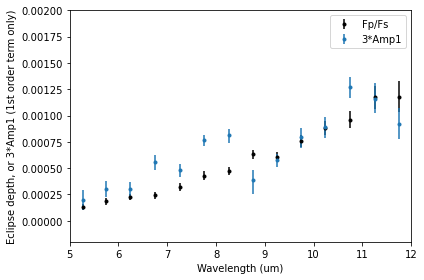

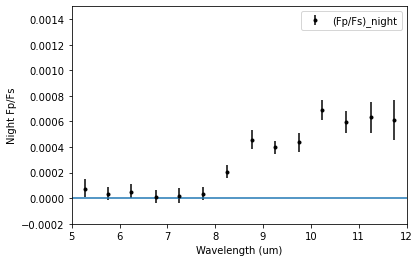

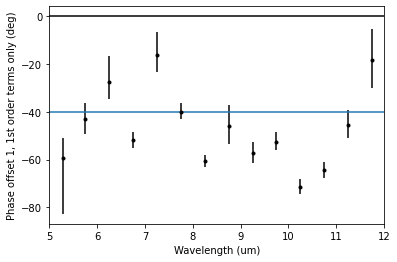

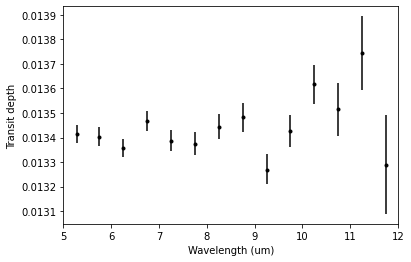

In [30]:
#Plot spectra.  Uncomment savefig to save.

plt.errorbar(wavelengths, Fp_med, yerr=[Fp_lower_err, Fp_upper_err], fmt='.', label="Fp/Fs", color='k')
plt.errorbar(wavelengths, 3*A_med, yerr=[3*A_lower_err, 3*A_upper_err], fmt='.', label="3*Amp1")
plt.xlim(5, 12)
plt.ylim(-200e-6, 2000e-6)
plt.legend()
plt.xlabel("Wavelength (um)")
plt.ylabel("Eclipse depth, or 3*Amp1 (1st order term only)")
plt.tight_layout()
plt.savefig("emission.png")
plt.figure()

plt.errorbar(wavelengths, night_Fp_med, yerr=[night_Fp_lower_err, night_Fp_upper_err], fmt='.', label="(Fp/Fs)_night", color='k')
plt.xlim(5, 12)
plt.ylim(-200e-6, 1500e-6)
plt.legend()
plt.xlabel("Wavelength (um)")
plt.ylabel("Night Fp/Fs")
plt.axhline(0)
plt.savefig("night_emission.png")
plt.figure()

plt.errorbar(wavelengths, phi_med, yerr=[phi_lower_err, phi_upper_err], fmt='.', color='k')
plt.xlim(5, 12)
plt.axhline(0, color='k')
plt.xlabel("Wavelength (um)")
plt.ylabel("Phase offset 1, 1st order terms only (deg)")
plt.axhline(-40)
plt.savefig("phase_offset1.png")
plt.figure()

plt.errorbar(wavelengths, RpRs_med**2, yerr=[2 * RpRs_med * RpRs_lower_err, 2 * RpRs_med * RpRs_upper_err], fmt='.', color='k')
plt.xlim(5, 12)
plt.xlabel("Wavelength (um)")
plt.ylabel("Transit depth")
plt.savefig("transit.png")

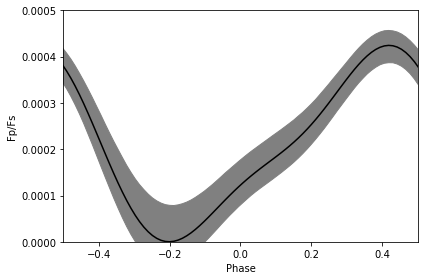

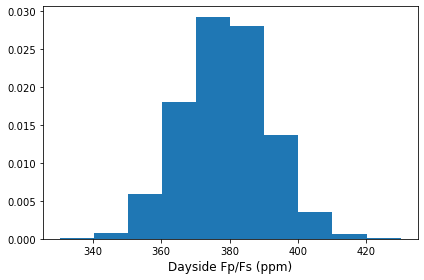

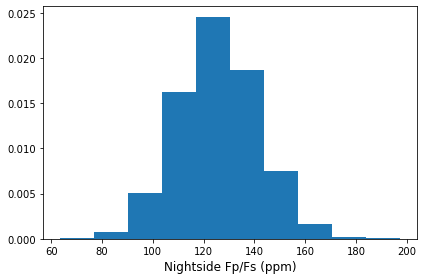

In [5]:
#Plot white phase curve, along with histograms of dayside flux and nightside flux
white_chain = np.load(dirname + "white_chain.npy")
white_lnprob = np.load(dirname + "white_lnprobs.npy")

Fp, C1, D1, C2, D2 = white_chain[:,2:7].T
model_phase = np.linspace(-0.6, 0.6, 100)
x = 2*np.pi*(model_phase - 0.5)
model_fluxes = Fp[:,np.newaxis] + C1[:,np.newaxis]*(np.cos(x) - 1) + D1[:,np.newaxis] * np.sin(x) + C2[:,np.newaxis]*(np.cos(2*x) - 1) + D2[:,np.newaxis]*np.sin(2*x)
lower_envelope = np.percentile(model_fluxes, 0.15, axis=0)
upper_envelope = np.percentile(model_fluxes, 99.85, axis=0)
best_fluxes = model_fluxes[np.argmax(white_lnprob)]

with open("white_envelope_3sigma.txt", "w") as f:
    f.write("#Phase Lower Upper Best\n")
    for i in range(len(model_phase)):
        f.write("{} {} {} {}\n".format(model_phase[i], lower_envelope[i], upper_envelope[i], best_fluxes[i]))

plt.fill_between(model_phase, lower_envelope, upper_envelope, color='gray')
plt.plot(model_phase, best_fluxes, color='black')
plt.ylim(0, 5e-4)
plt.xlim(-0.5, 0.5)
plt.xlabel("Phase")
plt.ylabel("Fp/Fs")
plt.tight_layout()
plt.savefig("white_phase_curve.png")

plt.figure()
plt.hist(1e6 * Fp, density=True)
plt.xlabel("Dayside Fp/Fs (ppm)", fontsize=12)
plt.tight_layout()
plt.savefig("white_day_Fp.png")

plt.figure()
plt.hist(1e6 * (Fp - 2*C1), density=True)
plt.xlabel("Nightside Fp/Fs (ppm)", fontsize=12)
plt.tight_layout()
plt.savefig("white_night_Fp.png")

STD 0 5000 119.10913760140916
STD 1 5500 108.78046948645844
STD 2 6000 103.48884398973938
STD 3 6500 107.7708301179724
STD 4 7000 114.99895317812667
STD 5 7500 123.51813737453035
STD 6 8000 131.95611147292485
STD 7 8500 146.2822020416385
STD 8 9000 152.1561194855394
STD 9 9500 167.29608405838073
STD 10 10000 221.0173563080975
STD 11 10500 290.8330181547182
STD 12 11000 418.20519918345315
STD 13 11500 578.0120740793511


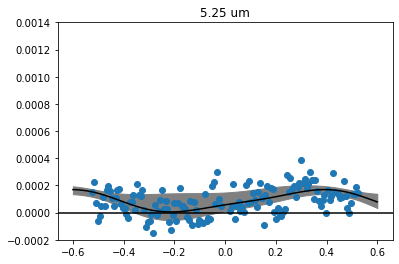

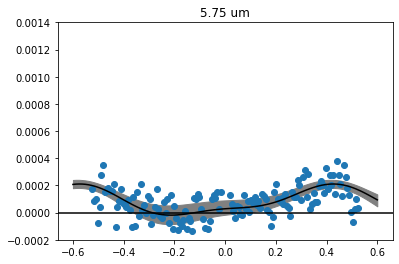

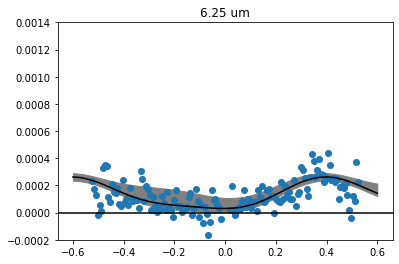

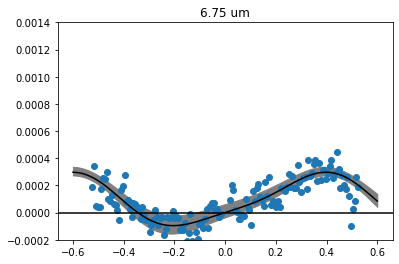

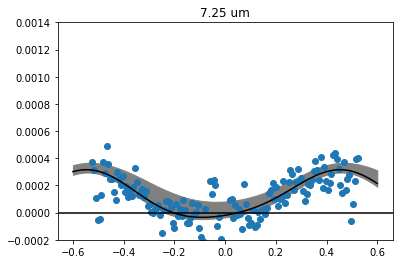

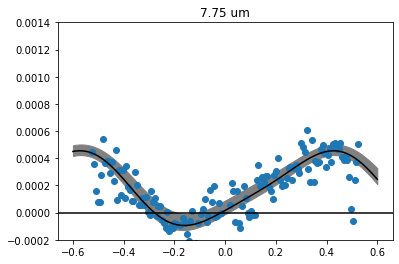

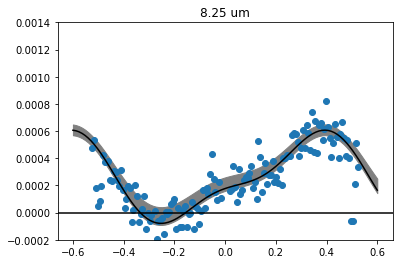

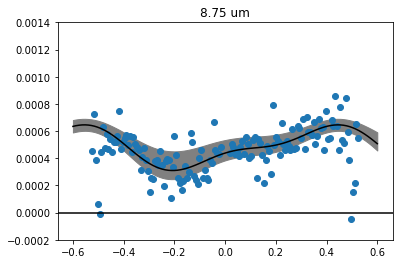

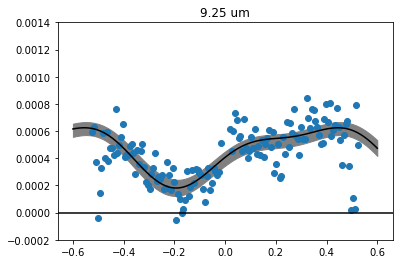

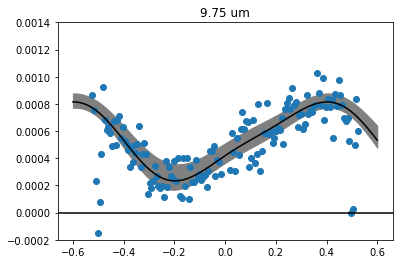

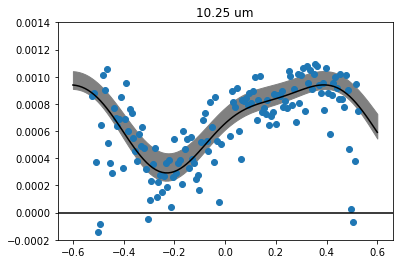

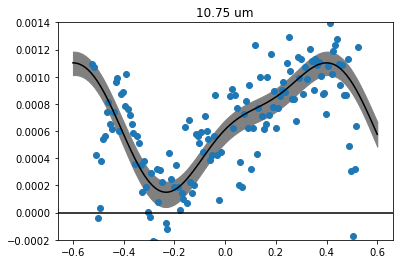

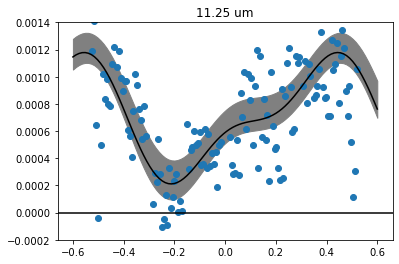

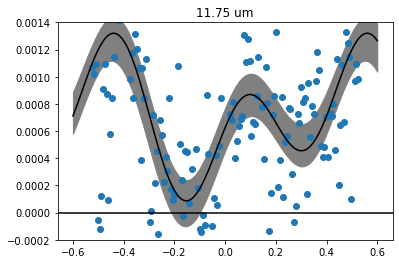

In [6]:
#Plot spectroscopic phase curves, with 1 sigma range
all_model_fluxes = []
start_wavelengths = np.arange(5000, 12000, 500)
center_wavelengths = start_wavelengths + np.median(np.diff(start_wavelengths)) / 2
lightcurves = np.loadtxt(dirname + "lightcurves.txt")
lightcurves_wavelengths = np.unique(lightcurves[:,0])
assert(len(center_wavelengths) == len(lightcurves_wavelengths))

for i,w in enumerate(start_wavelengths):    
    chain = np.load(dirname + "chain_{}_{}.npy".format(w, w+500))
    lnprob = np.load(dirname + "lnprobs_{}_{}.npy".format(w, w+500))
    
    cond = lightcurves[:,0] == lightcurves_wavelengths[i]
    data_phases = (lightcurves[:,1] - T0)[cond] / P
    data = (lightcurves[:,2] / lightcurves[:,4])[cond]
    residuals = lightcurves[:,-1][cond]
   
    Fp, C1, D1, C2, D2 = chain.T[0:5]
    model_phase = np.linspace(-0.6, 0.6, 100)
    x = 2*np.pi*(model_phase - 0.5)    
    model_fluxes = Fp[:,np.newaxis] + C1[:,np.newaxis]*(np.cos(x) - 1) + D1[:,np.newaxis] * np.sin(x) + C2[:,np.newaxis]*(np.cos(2*x) - 1) + D2[:,np.newaxis]*np.sin(2*x)
    all_model_fluxes.append(model_fluxes)
    lower_envelope = np.percentile(model_fluxes, 16, axis=0)
    upper_envelope = np.percentile(model_fluxes, 84, axis=0)
    best_flux = model_fluxes[np.argmax(lnprob)]
  
    plt.figure()
    plt.fill_between(model_phase, lower_envelope, upper_envelope, color='gray')
    plt.plot(model_phase, best_flux, color='k')
    plt.scatter(data_phases[70::140], uniform_filter(data, 140)[70::140] - 1)    
    print("STD", i, w, 1e6 * np.std(uniform_filter(residuals, 64)[32::64]))
    plt.title(str((w+250)/1000) + " um")
    plt.axhline(0, color='k')
    plt.ylim(-0.0002, 0.0014)
    filename = "phase_{}_{}.png".format(w, w+500)    
    plt.savefig(filename)
    
    with open("envelopes_{}_{}.txt".format(w, w+500), "w") as f:
        f.write("#Phase Lower Upper Best\n")
        for i in range(len(model_phase)):
            f.write("{} {} {} {}\n".format(model_phase[i], lower_envelope[i], upper_envelope[i], best_flux[i]))
    
all_model_fluxes = np.array(all_model_fluxes)

(14, 100)


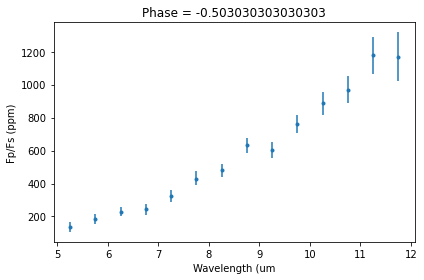

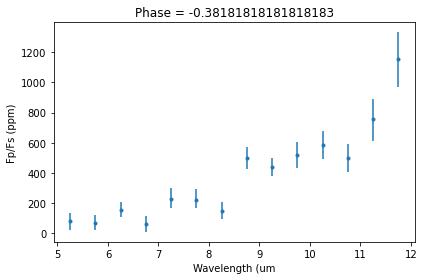

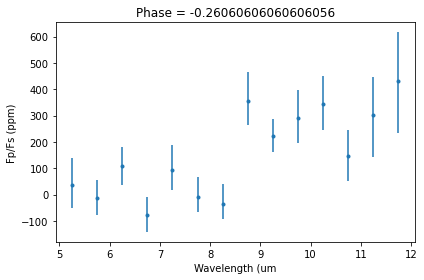

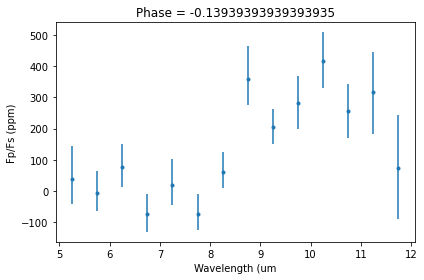

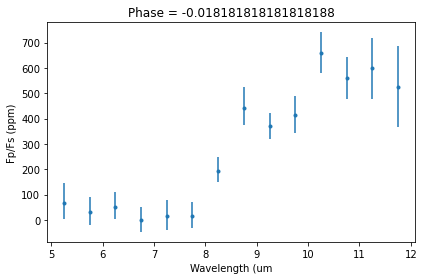

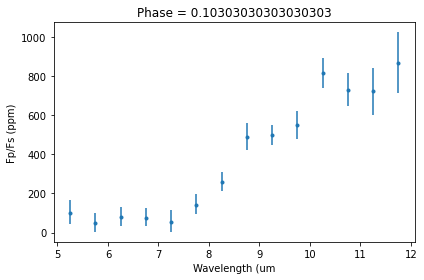

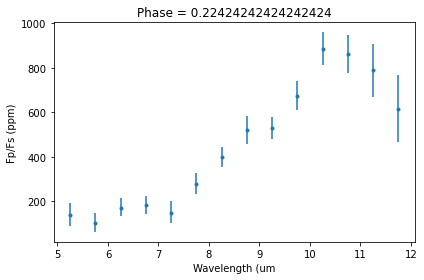

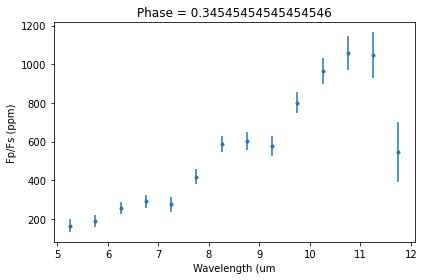

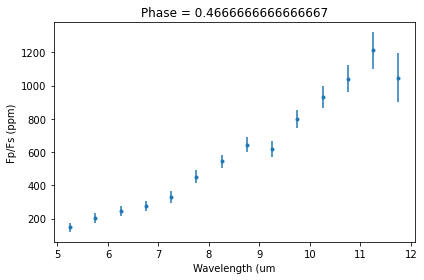

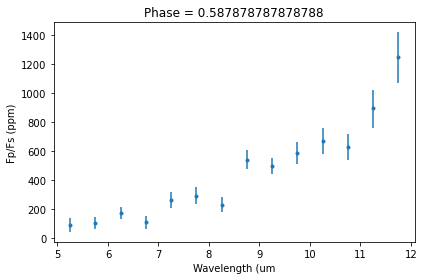

In [8]:
#Generate emission spectra at different phases

median = np.median(all_model_fluxes, axis=1)
upper = np.percentile(all_model_fluxes, 84, axis=1)
lower = np.percentile(all_model_fluxes, 16, axis=1)
print(median.shape)
center_wavelengths = start_wavelengths + np.median(np.diff(start_wavelengths))/2

for i in range(8, 100, 10):
    plt.figure()
    plt.errorbar(center_wavelengths/1000, 
                 1e6*median[:,i], yerr=1e6*np.array([median[:,i] - lower[:,i], upper[:,i] - median[:,i]]), fmt='.')
    plt.title("Phase = " + str(model_phase[i]))
    plt.xlabel("Wavelength (um")
    plt.ylabel("Fp/Fs (ppm)")
    plt.tight_layout()
    plt.savefig("emission_phase{}.png".format(i))

5840.012305113137
2.482944383856257e+26


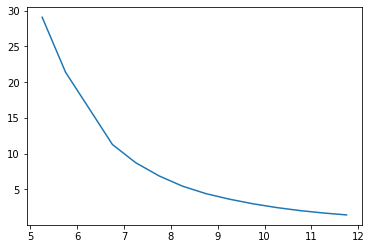

In [21]:
#The next few cells calculate the albedo of the planet

spectrum = fits.open("fiducial_stellar_spectrum.fits")[1].data
W_m_sqr_to_cgs = 1000
#print(spectrum)
start_wavelengths = np.arange(5, 12, 0.5)
end_wavelengths = start_wavelengths + 0.5
Fstar = np.zeros(len(start_wavelengths))
AU = 1.5e13
Rsun = 7e10
Rstar = 0.207 * Rsun
a_over_Rstar = 14.97
a = a_over_Rstar * Rstar
RpRs = 0.1161

for i in range(len(start_wavelengths)):
    cond = np.logical_and(spectrum["Wavelength"] >= start_wavelengths[i], spectrum["Wavelength"] < end_wavelengths[i])
    Fstar[i] = np.trapz(spectrum["Flux"][cond], spectrum["Wavelength"][cond]) * W_m_sqr_to_cgs * np.pi * (Rstar / AU)**2
    
stellar_flux = np.trapz(spectrum["Flux"], spectrum["Wavelength"]) * W_m_sqr_to_cgs * np.pi * (Rstar / AU)**2
print(stellar_flux)
received_power = stellar_flux * (AU/a)**2 * np.pi * (Rstar * RpRs)**2
print(received_power)
#print(received_luminosity)
#print(hdul[1].data.columns)
plt.plot((start_wavelengths + end_wavelengths) / 2, Fstar)

In [22]:
planet_fluxes = []

for i in range(len(model_phase)):
    phase = model_phase[i]
    rel_fluxes = all_model_fluxes[:,:,i]
    planet_fluxes.append((rel_fluxes * Fstar[:,np.newaxis]).sum(axis=0))

planet_fluxes = np.array(planet_fluxes)
print(planet_fluxes)
print(planet_fluxes.shape)

[[0.04109288 0.04075332 0.04218183 ... 0.04310515 0.04257711 0.03920836]
 [0.04122897 0.04093206 0.0422946  ... 0.04302661 0.04259172 0.03939176]
 [0.04119964 0.04097505 0.04228046 ... 0.0428361  0.04244801 0.03940693]
 ...
 [0.02746555 0.02977977 0.03160154 ... 0.03240306 0.02853243 0.02536893]
 [0.02563698 0.02816797 0.03014737 ... 0.03120713 0.02680844 0.02341948]
 [0.02378442 0.02651455 0.02866702 ... 0.03001633 0.02507515 0.02143263]]
(100, 200000)


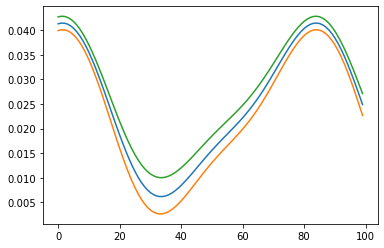

In [23]:
plt.plot(np.median(planet_fluxes, axis=1))
plt.plot(np.percentile(planet_fluxes, 16, axis=1))
plt.plot(np.percentile(planet_fluxes, 84, axis=1))

In [24]:
def print_stats(arr):
    print(np.median(arr), np.median(arr) - np.percentile(arr, 16), np.percentile(arr, 84) - np.median(arr))

avg_planet_fluxes = planet_fluxes.mean(axis=0)  #at 1 AU
radiated_power = 4 * np.pi * AU**2 * avg_planet_fluxes
print("Radiated power:")
print_stats(radiated_power)

frac_within_band = 0.54
anisotropy_factor = 1.08

albedos = 1 - (radiated_power / frac_within_band / anisotropy_factor) / received_power
print("Albedo median, lower err, upper error:")
print_stats(albedos)
#print(np.median(albedos), np.percentile(albedos, 16), np.percentile(albedos, 84))

Radiated power:
7.127258124736231e+25 5.70512576733686e+24 6.138942343938912e+24
Albedo median, lower err, upper error:
0.5078041125385586 0.04239445411080073 0.0393985932737273
